# Random subtypes
The purpose of this experiment is to explore the differences between random and non-random subtypes
## Hypothesis
1. Maps of random subtypes should have reduced extrema amplitudes (from averaging across different map types)
2. Maps of random subtypes should have less smooth features and should qualitatively look less plausible.
3. RMSE of random subtypes should be higher than that of non-random subtypes
## Method

1. Take the hierarchical organization of subject by subject similarity and randomize it before generating the subtypes
2. Average the maps like I would with the non-random subtypes
3. Compute the RMSE for each subject in the subgroup and record it
4. Compare the maps between random and non-random subtypes visually


In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 7
subtypes = 5
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']
mtp = mtp_list[1]

in_default = '{}_{}_scale_{:03d}'.format(mtp, name, scale)

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [6]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

In [7]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [8]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [9]:
n_sub = netstack.shape[2]

In [10]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [12]:
iterator = 100
# Percentile to look at
perc = 99

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

sbt_store = np.zeros((scale, subtypes, n_vox))
sbt_rand_store = np.zeros((scale, subtypes, n_vox))
part_store = np.zeros((scale, n_sub))
rmse_nonrand = np.zeros((scale, subtypes))
rmse_rand = np.zeros((scale, subtypes, iterator))
ext_rand = np.zeros((scale, subtypes, iterator))

# Iterate through the networks
for net_id in range(scale):
    print('Running network {} now'.format(net_id))
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub
    part_rand = np.copy(part_sub)
    
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        rmse_nonrand[net_id, s_id] = np.mean(np.sqrt(np.mean(np.square(sbt - netstack[net_id, :, part_sub==s_id+1]),1)))
        sbt_store[net_id, s_id, :] = sbt
     
    for it_id in np.arange(iterator):
        np.random.shuffle(part_rand)
        for s_id in range(subtypes):   
            sbt_rand = np.mean(netstack[net_id, :, part_rand==s_id+1],0)
            rmse_rand[net_id, s_id, it_id] = np.mean(np.sqrt(np.mean(np.square(sbt_rand - netstack[net_id, :, part_rand==s_id+1]),1)))
            sbt_rand_store[net_id, s_id, :] += sbt_rand            
            # Get the percentile
            ext_rand[net_id, s_id, it_id] = np.percentile(np.abs(sbt_rand), perc)

    sbt_rand_store[net_id, ...] /= iterator

Running network 0 now
Running network 1 now
Running network 2 now
Running network 3 now
Running network 4 now
Running network 5 now
Running network 6 now


## Hypothesis 1
Different extrema:

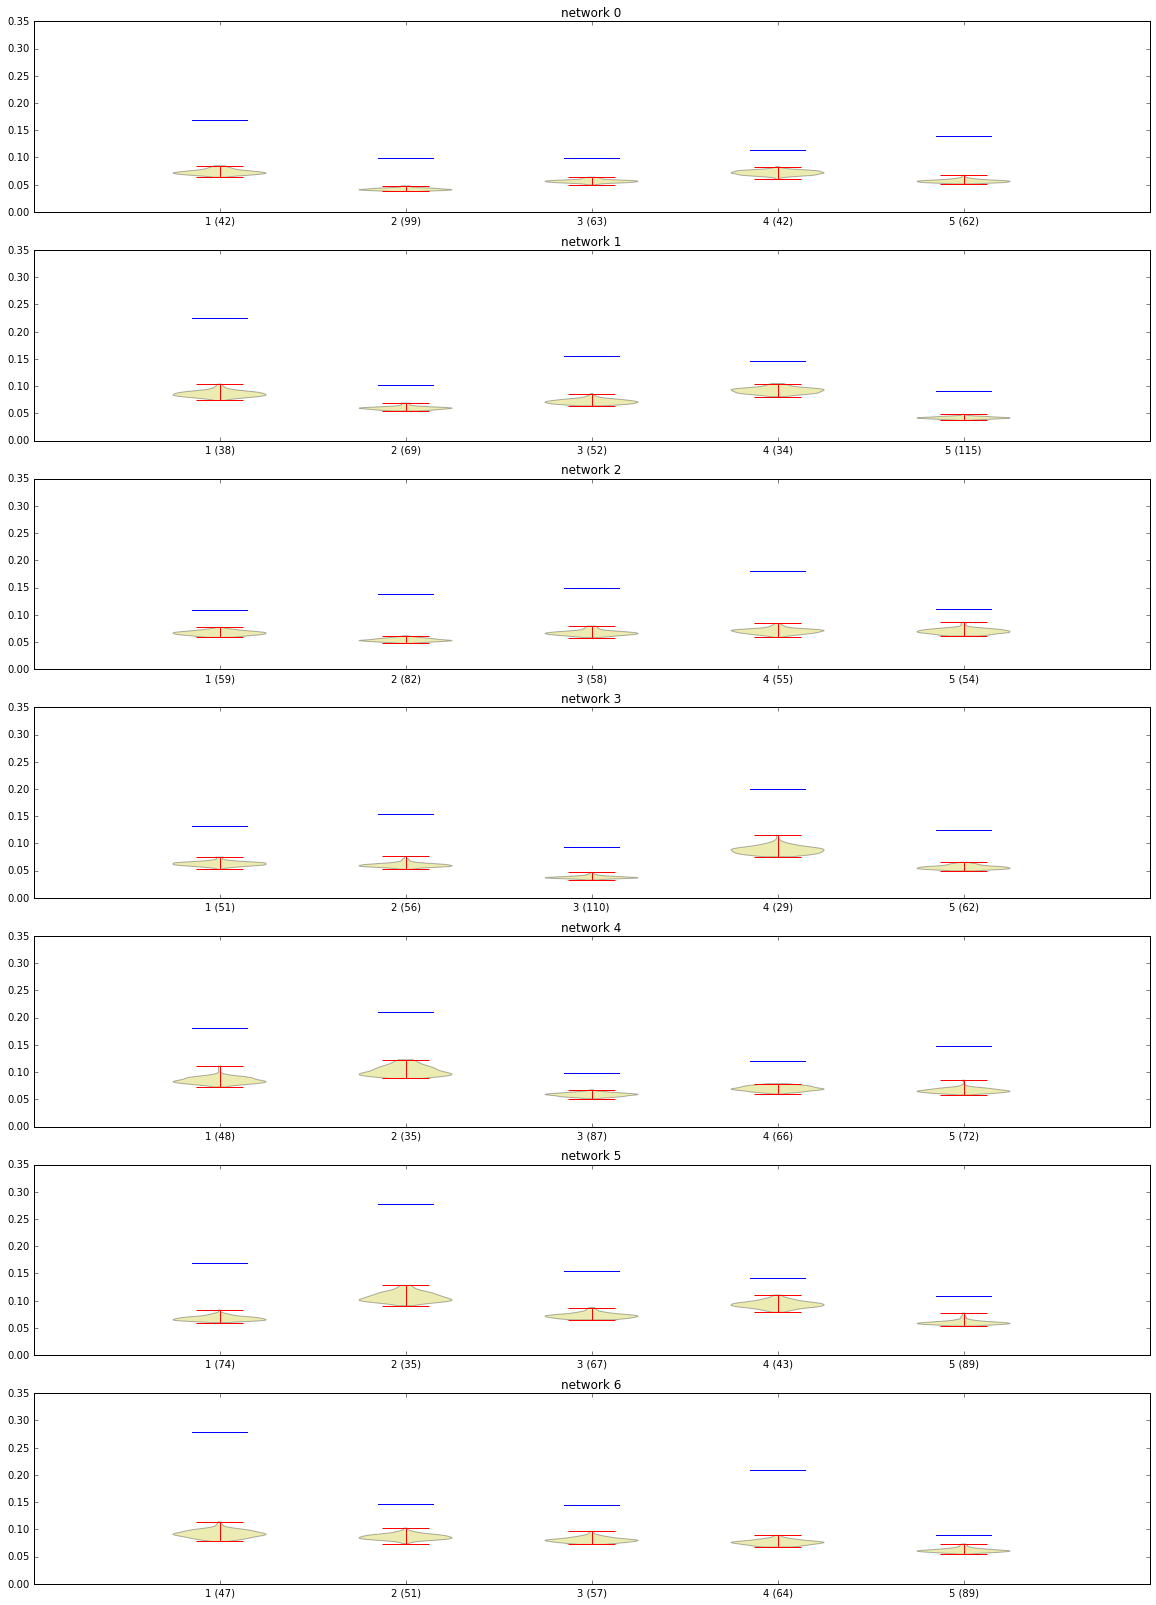

In [14]:
fig = plt.figure(figsize=(20,4*scale))
gs = gridspec.GridSpec(scale, 1)
ext_cut = (n_vox/100)*10
width = 0.3/2

for net_id in np.arange(scale):
    ext_list = [ext_rand[net_id, sbt_id, :] for sbt_id in np.arange(subtypes)]
    ax1 = fig.add_subplot(gs[net_id, 0])
    ax1.violinplot(ext_list)
    
    for sbt_id in np.arange(subtypes):
        t_pos = sbt_id + 1
        sbt_med = np.percentile(np.abs(sbt_store[net_id, sbt_id, :]), perc)
        ax1.plot([t_pos-width, t_pos+width], [sbt_med, sbt_med], 'b')

    # Make xtick labels with the number of subjects in the subtype
    x_labels = ['{} ({})'.format(sbt_id+1, np.sum(part_store[net_id,:] == sbt_id+1)) for sbt_id in np.arange(subtypes)]
    x_ticks = np.arange(1,subtypes+1)
    
    ax1.set_title('network {}'.format(net_id))
    ax1.set_ylim([0, 0.35])
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)

## Hypothesis 2
maps of random subtypes are less smooth and look less anatomically plausible

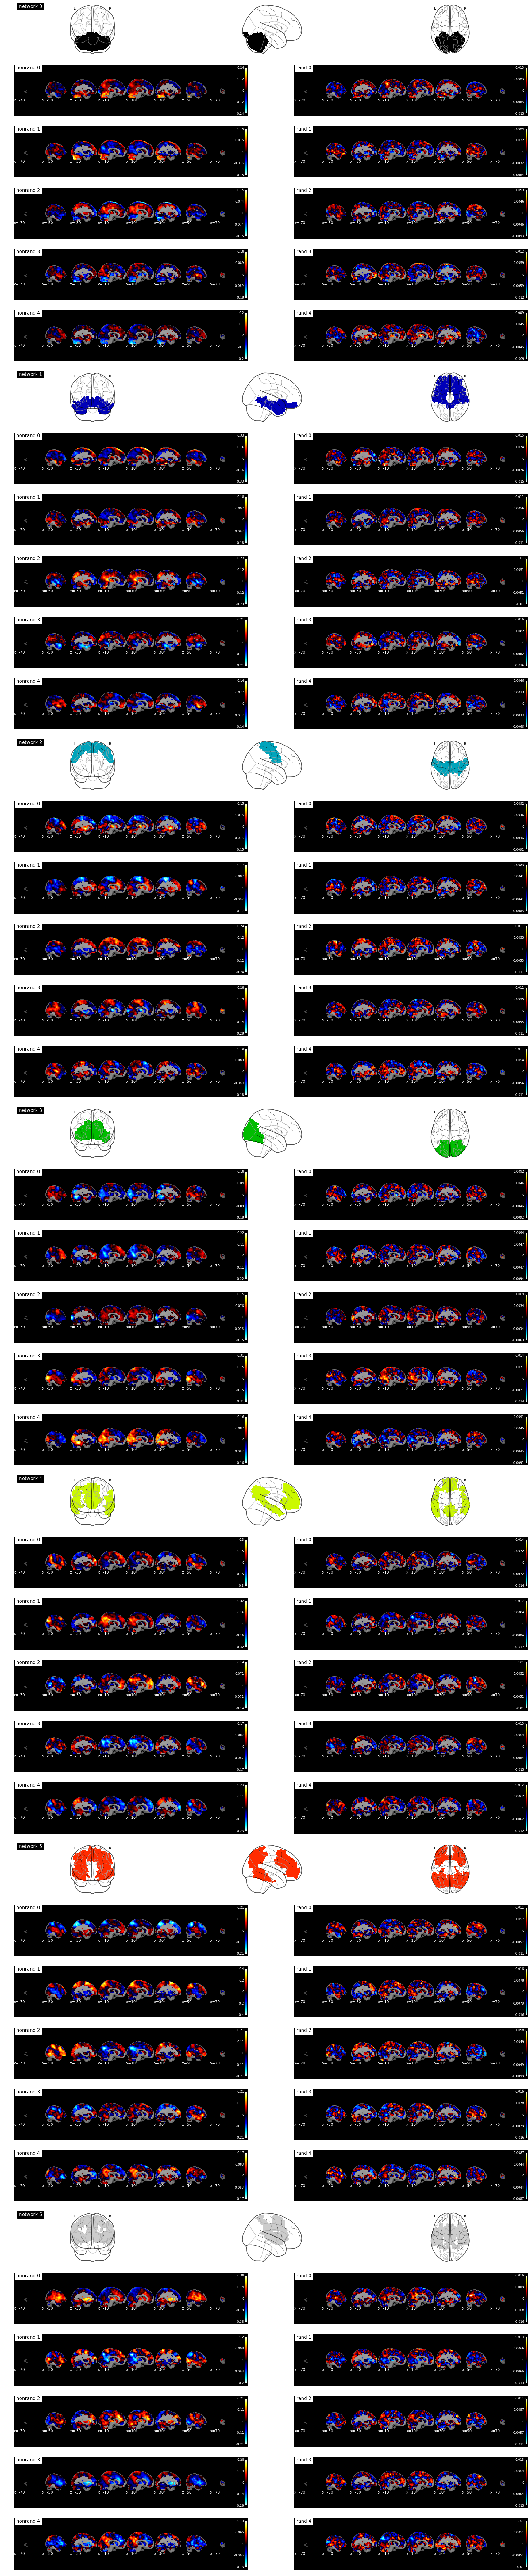

In [15]:
# Visualize the differences
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]
# Have them side by side:
fig = plt.figure(figsize=(30,150))
gs = gridspec.GridSpec(np.prod((scale, subtypes))+scale, 2)
for net_id in np.arange(scale):
    p_id_net = net_id*(subtypes + 1)
    ax = fig.add_subplot(gs[p_id_net, :])
    nlp.plot_glass_brain(nil.image.index_img(prior_img, net_id), cmap=plt.cm.spectral, 
                         colorbar=False, vmin=1, vmax=scale, axes=ax, title='network {}'.format(net_id))
    for sbt_id in np.arange(subtypes):
        p_id_sbt = p_id_net + sbt_id + 1
        ax_nonrand = fig.add_subplot(gs[p_id_sbt, 0])
        ax_rand = fig.add_subplot(gs[p_id_sbt, 1])
        
        # Nonrand
        sbt = sbt_store[net_id, sbt_id,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, 
                          cut_coords=view_range, black_bg=True,
                          axes=ax_nonrand, title='nonrand {}'.format(sbt_id))
        # Rand
        sbt = sbt_rand_store[net_id, sbt_id,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, 
                          cut_coords=view_range, black_bg=True,
                          axes=ax_rand, title='rand {}'.format(sbt_id))    

## Hypothesis 3
RMSE of random subtypes are higher than that of non-random subtypes

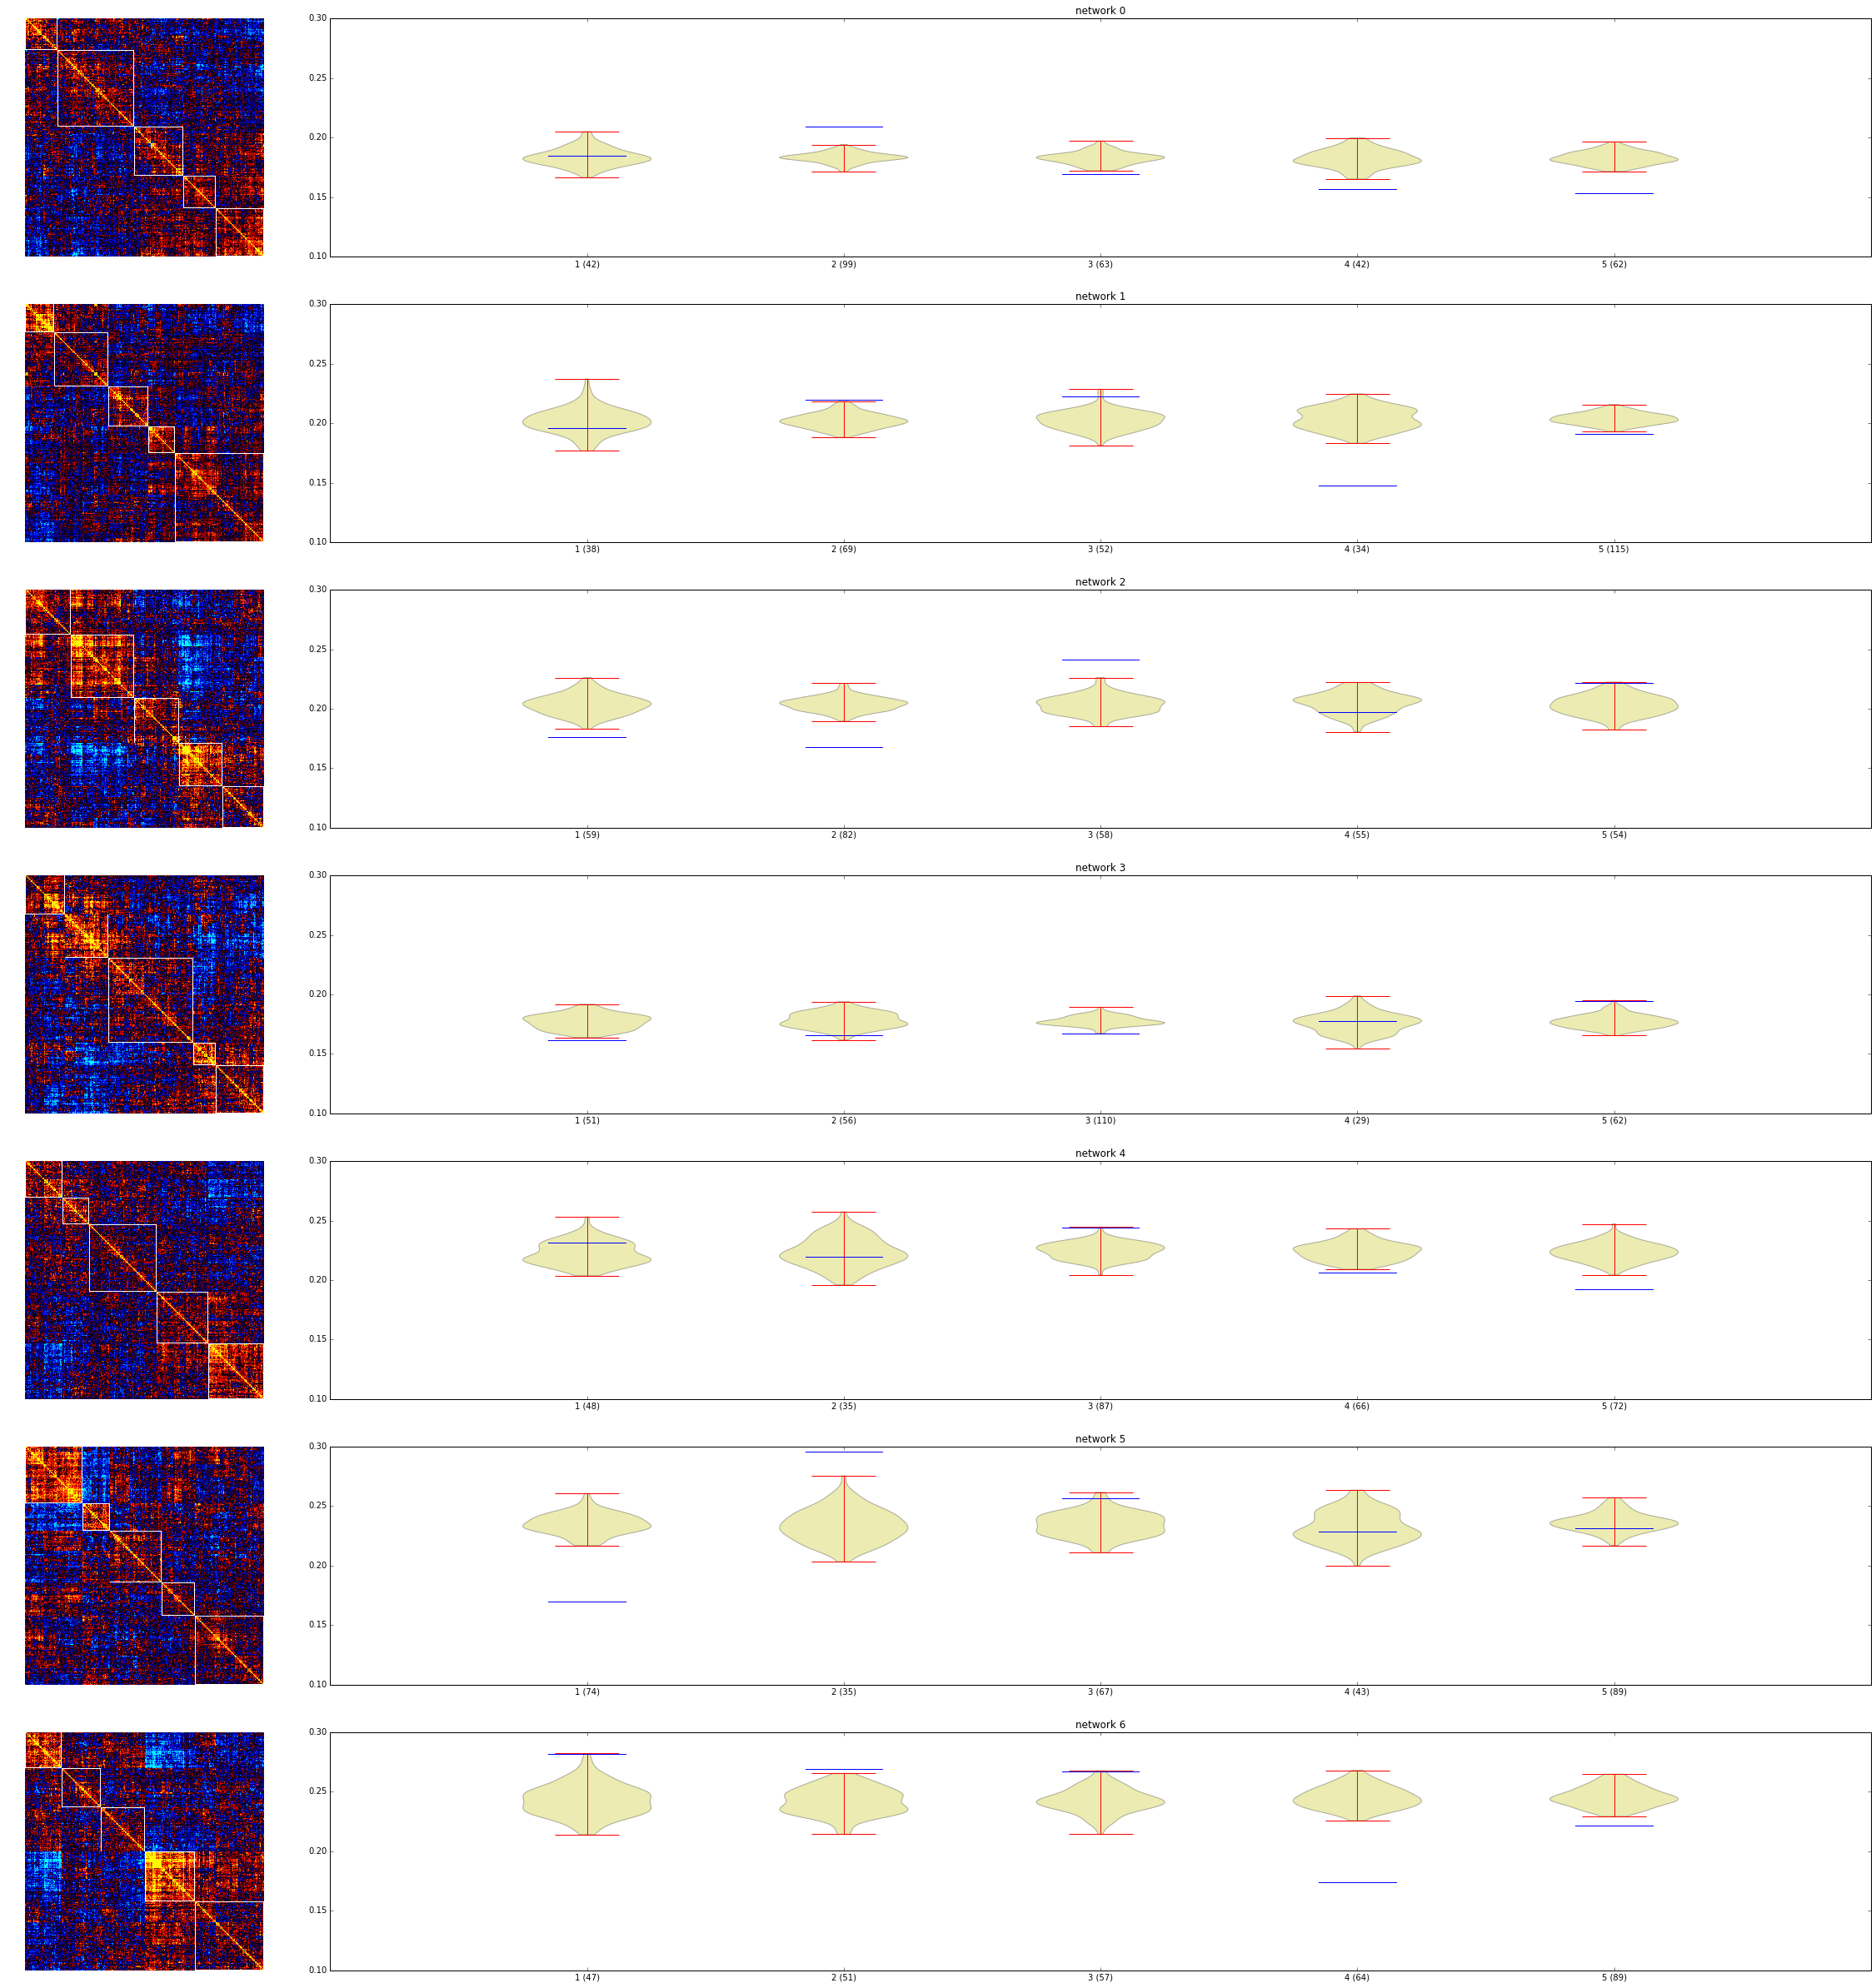

In [21]:
fig = plt.figure(figsize=(40,6*scale))
gs = gridspec.GridSpec(scale, 6)
ext_cut = (n_vox/100)*10
width = 0.3/2

for net_id in np.arange(scale):
    ax1 = fig.add_subplot(gs[net_id, 0])
    # Get the subtype segmentation
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, :] , method='ward')
    ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
    part_test = part_store[net_id][ind]
    part_frame = np.zeros((n_sub, n_sub))
    
    for sbt_id in np.arange(subtypes):
        # Get first and last element
        first = np.where(part_test==sbt_id+1)[0][0]
        last = np.where(part_test==sbt_id+1)[0][-1]
        # Draw column
        part_frame[first:last, (first, last)] = 1
        # Draw rows
        part_frame[(first, last), first:last] = 1
    part_frame = np.ma.masked_where(part_frame == 0, part_frame)
    
    ax1.matshow(corr_mat[net_id, :][ind,:][:, ind], vmin=-0.2, vmax=0.2, cmap=hotcold)
    ax1.matshow(part_frame, cmap=plt.cm.Greys)
    ax1.set_axis_off()
    
    rmse_list = [rmse_rand[net_id, sbt_id, :] for sbt_id in np.arange(subtypes)]
    ax2 = fig.add_subplot(gs[net_id, 1:])
    ax2.violinplot(rmse_list)
    
    for sbt_id in np.arange(subtypes):
        t_pos = sbt_id + 1
        sbt_rmse = rmse_nonrand[net_id, sbt_id]
        ax2.plot([t_pos-width, t_pos+width], [sbt_rmse, sbt_rmse], 'b')

    # Make xtick labels with the number of subjects in the subtype
    x_labels = ['{} ({})'.format(sbt_id+1, np.sum(part_store[net_id,:] == sbt_id+1)) for sbt_id in np.arange(subtypes)]
    x_ticks = np.arange(1,subtypes+1)
    
    ax2.set_title('network {}'.format(net_id))
    ax2.set_ylim([0.10, 0.3])
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels)